In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#vgg16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import classification_report,confusion_matrix

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od

In [4]:
od.download('https://www.kaggle.com/datasets/tongpython/cat-and-dog')

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog


100%|██████████| 218M/218M [00:00<00:00, 587MB/s]


In [5]:
train_dir = '/content/cat-and-dog/training_set/training_set'
test_dir  = '/content/cat-and-dog/test_set/test_set'

print(train_dir)
print(test_dir)

/content/cat-and-dog/training_set/training_set
/content/cat-and-dog/test_set/test_set


In [6]:
print('Train Cats :',len(os.listdir(train_dir +'/cats')))
print('Train Dogs :',len(os.listdir(train_dir +'/dogs')))
print('Test Cats :',len(os.listdir(test_dir +'/cats')))
print('Test Dogs :',len(os.listdir(test_dir +'/dogs')))

Train Cats : 4001
Train Dogs : 4006
Test Cats : 1012
Test Dogs : 1013


# use generator

In [7]:
img_size=(150,150)
batch_size=32

train_datagen=ImageDataGenerator(
    preprocessing_function= preprocess_input,   #vgg16 preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen=ImageDataGenerator(
    preprocessing_function= preprocess_input
)


train_gen=train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',   # cat/dog -> one-hot (2 outputs)
    subset='training'
)

val_gen=train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_gen=test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False

)


print("Classes:", train_gen.class_indices)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Classes: {'cats': 0, 'dogs': 1}


# load pre-train vgg16

In [8]:
base_model=VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(150,150,3)
)
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#Freeze VGG16 Convolution Layers

In [9]:
base_model.trainable=False

for layer in base_model.layers:
  layer.trainable=False

#Fully Connected Layers

In [10]:
inputs=keras.Input(shape=(150,150,3))

# Pass input through VGG16 base
x=base_model(inputs,training=False)


# Convert feature maps to vector
x=layers.GlobalAveragePooling2D()(x)

# Custom classification layers ("Cat" layers as they wrote)
x=layers.Dense(256,activation='relu')(x)
x=layers.Dropout(0.4)(x)

# Output layer
outputs=layers.Dense(2,activation='softmax')(x)

# Create model
model=keras.Model(inputs,outputs)
model.summary()

model = keras.Model(inputs, outputs)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

#compile model

In [11]:
optimizers=SGD(learning_rate=0.01,momentum=0.9)

model.compile(
    optimizer=optimizers,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#train the model


In [13]:
history=model.fit(train_gen,epochs=20,validation_data=val_gen)

Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 67s 331ms/step - accuracy: 0.9171 - loss: 0.1957 - val_accuracy: 0.9475 - val_loss: 0.2925
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - accuracy: 0.9120 - loss: 0.2144 - val_accuracy: 0.9500 - val_loss: 0.1484
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 57s 283ms/step - accuracy: 0.9358 - loss: 0.1680 - val_accuracy: 0.9513 - val_loss: 0.1599
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - accuracy: 0.9343 - loss: 0.1654 - val_accuracy: 0.9494 - val_loss: 0.1385
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - accuracy: 0.9421 - loss: 0.1565 - val_accuracy: 0.9500 - val_loss: 0.1382
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 66s 331ms/step - accuracy: 0.9347 - loss: 0.1545 - val_accuracy: 0.9563 - val_loss: 0.1807
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 57s 283ms/step - accuracy: 0.9344 - loss: 0.1861 - val_accuracy: 0.9519 - val_loss: 0.1521
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - accuracy: 0.9420 - loss: 0

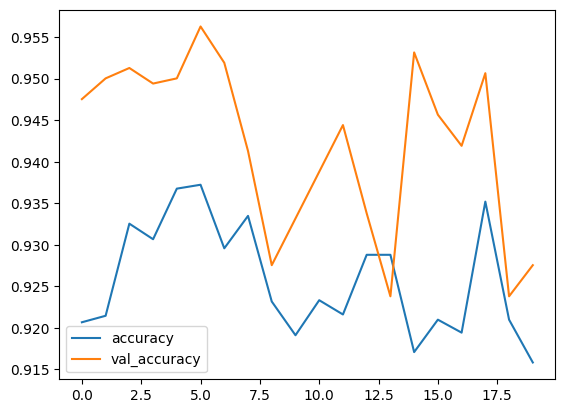

In [14]:
#plot
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

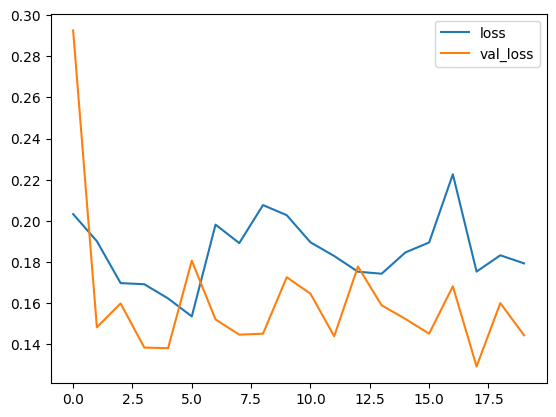

In [15]:
#loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()


#evaluate model

In [17]:
test_loss,test_acc=model.evaluate(test_gen)
print('Test Accuracy:',test_acc)
print('Test loss',test_loss)

64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9694 - loss: 0.3794
Test Accuracy: 0.9569945335388184
Test loss 0.19941946864128113


In [19]:
y_prob=model.predict(test_gen)
y_pred=np.argmax(y_prob,axis=1)
y_true=test_gen.classes

64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step


In [26]:
print(classification_report(y_true,y_pred, target_names=list(test_gen.class_indices.keys())))

              precision    recall  f1-score   support

        cats       0.94      0.98      0.96      1011
        dogs       0.98      0.93      0.96      1012

    accuracy                           0.96      2023
   macro avg       0.96      0.96      0.96      2023
weighted avg       0.96      0.96      0.96      2023



In [21]:
print(confusion_matrix(y_true,y_pred))

[[990  21]
 [ 66 946]]


In [27]:
model.save('vgg16first.h5')

In [28]:
from tensorflow.keras.models import load_model
loaded_model=load_model('vgg16first.h5')

In [29]:
loaded_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,532 (56.64 MB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)

In [34]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

def predict_any_image(loaded_model,img_path,target_size,class_names,preprocess_fn=None):
    """
    Universal image predictor
    model        -> trained model
    img_path     -> path to image
    target_size  -> (H, W) expected by the model
    class_names  -> list of labels like ['cat','dog']
    preprocess_fn -> preprocessing function (optional, e.g., preprocess_input for VGG)
    """

    # Load & resize image
    img=load_img(img_path,target_size=target_size)

    # Convert to array
    x=img_to_array(img)

    # Normalize if preprocess not provided
    if preprocess_fn is None:
      x = x / 255
    else:
      x = preprocess_fn(x)

    # Add batch dimension
    x = np.expand_dims(x, axis=0)

    # Predict
    pred = loaded_model.predict(x)[0]

    # If sigmoid output → convert to 2-class softmax style
    if len(pred.shape) == 0 or len(pred) == 1:
        pred = np.array([1 - pred, pred])  # make 2-class style

    # Get class index & confidence
    cls_idx = np.argmax(pred)
    cls_name = class_names[cls_idx]
    confidence = pred[cls_idx]

    # Show image
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{cls_name} ({confidence:.2f})")
    plt.show()

    # Print output
    print("Predicted:", cls_name)
    print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


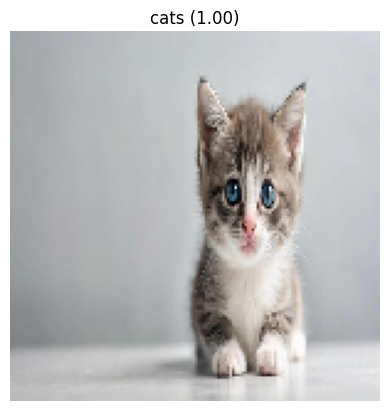

Predicted: cats
Confidence: 1.0


In [42]:
from tensorflow.keras.applications.vgg16 import preprocess_input

class_names = list(train_gen.class_indices.keys())

predict_any_image(
    loaded_model=loaded_model,
    img_path="/content/cute-cat.jpg",
    target_size=(150,150),
    class_names=class_names,
    preprocess_fn=lambda x: preprocess_input(np.expand_dims(x,0))[0]
)
